In [ ]:
# What version of Python do you have?
import sys


import pandas as pd
import sklearn as sk
import platform
import math
import pyreadr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pyreadr


from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

print(f"Python Platform: {platform.platform()}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-14.2-arm64-arm-64bit

Python 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 10:07:17) [Clang 14.0.6 ]
Pandas 2.2.2
Scikit-Learn 1.4.2
GPU is NOT AVAILABLE


In [11]:
import os
notebook_dir = "/Users/monamousavi/Dropbox/Causal_climate/My_own_Shared/Causal-ML-continuous-treatment"  
os.chdir(notebook_dir)  # Change directory
print(os.getcwd())  


/Users/monamousavi/Dropbox/Causal_climate/My_own_Shared/Causal-ML-continuous-treatment


In [12]:
data_2nd_stage = pyreadr.read_r(r'./Data/data_20230504/data_2nd_stage.rds')[None] 
evall_N_seq = pyreadr.read_r(r'./Data/data_20230504/evall_N_seq.rds')[None] 



In [ ]:
# Test ##########################

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pyreadr

# Pytorch model 
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Each branch processes x (first 3 columns) and multiplies its output by T.
        self.branch1 = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.branch2 = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.branch3 = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, inp):
        # inp is of shape (batch_size, 6)
        x = inp[:, :3]         # first three columns (features for the dense layers)
        T = inp[:, 3:]         # last three columns (scaling factors)
        T1 = T[:, 0:1]         # keep as (batch_size, 1)
        T2 = T[:, 1:2]
        T3 = T[:, 2:3]
        
        out1 = self.branch1(x) * T1
        out2 = self.branch2(x) * T2
        out3 = self.branch3(x) * T3
        output = out1 + out2 + out3
        return output

def train_model(n_fields):
    """
    Train model using training simulations from a CSV file and dataset
    selected based on the number of fields (1, 5, or 10).
    
    Parameters:
    - n_fields: int, one of {1, 5, 10}, which showes the training simulations.
    """
    
    # Load the R data files.
    #data_2nd_stage = pyreadr.read_r(r'./data_20230504/data_2nd_stage.rds')[None]
    #evall_N_seq = pyreadr.read_r(r'./data_20230504/evall_N_seq.rds')[None]
    
    # Set the df_train_sim_id file path based on n_fields.
    if n_fields == 5:
        df_train_sim_id_path = './Data/Train_5field/df_train_sim_id.csv'
        folder_name = "Pytorch_outcome_five_fields"
    elif n_fields == 10:
        df_train_sim_id_path = './Data/Train_10fields/df_train_sim_id.csv'
        folder_name = "Pytorch_outcome_ten_fields"
    elif n_fields == 1:
        df_train_sim_id_path = './Data/Train_1field/df_train_sim_id.csv'
        folder_name = "Pytorch_outcome_one_field"
    else:
        raise ValueError("Unsupported number of fields. Use 1, 5, or 10.")
        
    # Create the output folder if it does not exist.
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    df_train_sim_id = pd.read_csv(df_train_sim_id_path)
    
    # Set device (GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Get unique simulation ids from data_2nd_stage.
    sim_ids_all = np.unique(data_2nd_stage.sim)
    num = len(sim_ids_all)
    
    # Loop over simulation indices.
    for j in tqdm(range(1)):
        # Get test simulation id.
        sim_ids = np.unique(data_2nd_stage.sim)
        sim_id_test = sim_ids[j]
        
        # Get training simulation ids from df_train_sim_id.
       
        sim_id_train = np.array(df_train_sim_id.iloc[1])
        sim_id_train = np.delete(sim_id_train, 0, axis=0)
        # Select only the first n_fields simulation ids.
        sim_id_train = sim_id_train[:n_fields]
        
        # Select training dataset using the training simulation ids.
        dataset = data_2nd_stage[data_2nd_stage['sim'].isin(sim_id_train)].reset_index(drop=True)
       
        dataset = dataset[['y_tilde', 'Nk', 'plateau', 'b0', 'T_1_tilde', 'T_2_tilde', 'T_3_tilde']]
        
    return dataset


dataset=train_model(5)

100%|██████████| 1/1 [00:00<00:00, 59.38it/s]


In [35]:
dataset

,y_tilde,Nk,plateau,b0,T_1_tilde,T_2_tilde,T_3_tilde
0,-2398.883188,221.743023,15537.346109,7507.553932,1.147351,-0.217652,-1.487821
1,-1864.915476,227.235207,15934.942822,8063.057856,1.021726,-0.218522,-1.324436
2,-2675.451932,229.124976,15668.887161,7881.399140,1.012825,-0.208665,-1.303396
3,-2720.286772,229.157598,15812.791793,8460.388307,1.149349,-0.254346,-1.471501
4,-2697.427272,228.932459,16248.245535,9282.668188,1.061354,-0.287459,-1.486996
...,...,...,...,...,...,...,...
7195,619.477529,192.786558,16643.650528,8306.668361,-0.818284,0.234066,-0.558245
7196,186.249427,194.142652,17043.347694,8523.798821,-0.873033,0.201050,-0.579267
7197,132.847945,198.493031,17161.119102,8560.705951,-0.801393,0.252787,-0.516588
7198,373.604635,201.036948,16986.189038,8699.297147,-0.830974,0.213181,-0.544295


In [ ]:


import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pyreadr

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Each branch processes x (first 3 columns) and multiplies its output by T.
        self.branch1 = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.branch2 = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.branch3 = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, inp):
        # inp is of shape (batch_size, 6)
        x = inp[:, :3]         # first three columns (features for the dense layers)
        T = inp[:, 3:]         # last three columns (scaling factors)
        T1 = T[:, 0:1]         # keep as (batch_size, 1)
        T2 = T[:, 1:2]
        T3 = T[:, 2:3]
        
        out1 = self.branch1(x) * T1
        out2 = self.branch2(x) * T2
        out3 = self.branch3(x) * T3
        output = out1 + out2 + out3
        return output

def train_model(n_fields):
    """
    Train model using training simulations from a CSV file and dataset
    selected based on the number of fields (1, 5, or 10).
    
    Parameters:
    - n_fields: int, one of {1, 5, 10}, which determines the training simulations to use.
    """
    
    # Load the R data files.
    #data_2nd_stage = pyreadr.read_r(r'./data_20230504/data_2nd_stage.rds')[None]
    #evall_N_seq = pyreadr.read_r(r'./data_20230504/evall_N_seq.rds')[None]
    
    # Set the df_train_sim_id file path based on n_fields.
    if n_fields == 5:
        df_train_sim_id_path = './Data/Train_5field/df_train_sim_id.csv'
        folder_name = "Pytorch_outcome_five_fields"
    elif n_fields == 10:
        df_train_sim_id_path = './Data/Train_10fields/df_train_sim_id.csv'
        folder_name = "Pytorch_outcome_ten_fields"
    elif n_fields == 1:
        df_train_sim_id_path = './Data/Train_1field/df_train_sim_id.csv'
        folder_name = "Pytorch_outcome_one_field"
    else:
        raise ValueError("Unsupported number of fields. Use 1, 5, or 10.")
        
   
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    df_train_sim_id = pd.read_csv(df_train_sim_id_path)
    
    # Set device (GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Get unique simulation ids from data_2nd_stage.
    sim_ids_all = np.unique(data_2nd_stage.sim)
    num = len(sim_ids_all)
    
    # Loop over simulation indices.
    for j in tqdm(range(2)):
        # Get test simulation id.
        sim_ids = np.unique(data_2nd_stage.sim)
        sim_id_test = sim_ids[j]
        
        # Get training simulation ids from df_train_sim_id.
        
        sim_id_train = np.array(df_train_sim_id.iloc[1])
        sim_id_train = np.delete(sim_id_train, 0, axis=0)
        # Select only the first n_fields simulation ids.
        sim_id_train = sim_id_train[:n_fields]
        
        # Select training dataset using the training simulation ids.
        dataset = data_2nd_stage[data_2nd_stage['sim'].isin(sim_id_train)].reset_index(drop=True)
       
        dataset = dataset[['y_tilde', 'Nk', 'plateau', 'b0', 'T_1_tilde', 'T_2_tilde', 'T_3_tilde']]
        
        # Split into training and validation sets.
        train_dataset = dataset.sample(frac=0.8, random_state=0)
        val_dataset = dataset.drop(train_dataset.index)
        
        # Separate features and labels.
        train_features = train_dataset.copy()
        val_features = val_dataset.copy()
        train_labels = train_features.pop('y_tilde')
        val_labels = val_features.pop('y_tilde')
        
        # Standardize the features based on training data.
        scaler = StandardScaler()
        scaler.fit(train_features)
        scaled_train_features = scaler.transform(train_features)
        scaled_val_features = scaler.transform(val_features)
        
        # Convert numpy arrays to PyTorch tensors.
        X_train = torch.tensor(scaled_train_features, dtype=torch.float32).to(device)
        y_train = torch.tensor(train_labels.values, dtype=torch.float32).unsqueeze(1).to(device)
        X_val = torch.tensor(scaled_val_features, dtype=torch.float32).to(device)
        y_val = torch.tensor(val_labels.values, dtype=torch.float32).unsqueeze(1).to(device)
        
        # Create DataLoader for training data.
        train_dataset_tensor = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset_tensor, batch_size=512, shuffle=True)
        
        # Initialize the model, loss function and optimizer.
        model = MyModel().to(device)
        criterion = nn.L1Loss()  # mean absolute error loss.
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Training loop with early stopping.
        best_val_loss = np.inf
        patience = 10
        counter = 0
        num_epochs = 500
        
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * batch_X.size(0)
                
            train_loss = running_loss / len(train_loader.dataset)
            
            # Evaluate on validation set.
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val)
                val_loss = criterion(val_outputs, y_val).item()
            
            # Early stopping check.
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
            else:
                counter += 1
            
            if counter >= patience:
                print(f"Early stopping at epoch {epoch} for sim_id {sim_id_test}")
                break
            # Optional: print progress
            # print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}")
        
        # Predict on validation set.
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val).cpu().numpy().flatten()
        
        outcome_val = pd.DataFrame({'pred': val_preds, 'true': val_labels.values})
        outcome_val.to_csv(os.path.join(folder_name, f'validation_{sim_id_test}.csv'), index=False)
        
        ## EONR estimation.
        p_corn = 6.25 / 25.4  
        p_N = 1 / 0.453592
        
        test_dataset = data_2nd_stage[data_2nd_stage['sim'] == sim_id_test]
        features = test_dataset[['Nk', 'plateau', 'b0']]
        
        test_evall_N_seq = evall_N_seq[evall_N_seq['sim'] == sim_id_test].reset_index(drop=True)
        Nseq = test_evall_N_seq['N'].values
        n_row = test_dataset.shape[0]
        
        estEONR_vector = []
        
        # Loop over each row in the test dataset to estimate EONR.
        for i in range(n_row):
            feature_1 = features.iloc[i, :]
            rep_feature_1 = pd.concat([feature_1] * 100, axis=1).T
            rep_feature_1.reset_index(drop=True, inplace=True)
            rep_feature_1 = pd.concat([rep_feature_1, test_evall_N_seq.iloc[:, 0:3]], axis=1)
            rep_feature_1.rename(columns={'T_1': 'T_1_tilde', 'T_2': 'T_2_tilde', 'T_3': 'T_3_tilde'}, inplace=True)
            
            # Scale the features using the previously fitted scaler.
            scaled_feature_1 = scaler.transform(rep_feature_1)
            X_feature = torch.tensor(scaled_feature_1, dtype=torch.float32).to(device)
            
            with torch.no_grad():
                prediction = model(X_feature).cpu().numpy().reshape(-1)
            
            MP = prediction * p_corn - Nseq * p_N
            estEONR = Nseq[np.argmax(MP)]
            estEONR_vector.append(estEONR)
        
        outcome = pd.DataFrame({'pred': estEONR_vector, 'true': test_dataset['opt_N'].values})
        outcome.to_csv(os.path.join(folder_name, f'EONR_{sim_id_test}.csv'), index=False)

# Example usage:
# To train using five fields:
train_model(5)

# To train using ten fields:
# train_model(10)

# To train using one field:
# train_model(1)


  0%|          | 0/2 [00:00<?, ?it/s]

Early stopping at epoch 107 for sim_id 1


 50%|█████     | 1/2 [00:22<00:22, 22.80s/it]

Early stopping at epoch 126 for sim_id 2


100%|██████████| 2/2 [00:44<00:00, 22.21s/it]


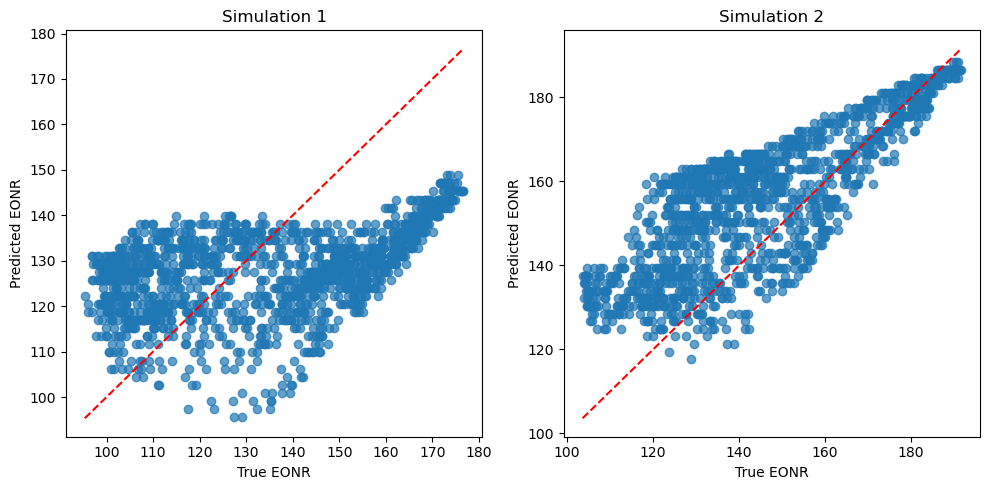

In [37]:
import glob
import math
import pandas as pd
import matplotlib.pyplot as plt

# all EONR CSV files
file_list = glob.glob('./Pytorch_outcome_five_fields/EONR_*.csv')
num_files = len(file_list)

# grid layout
cols = 2
rows = math.ceil(num_files / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)

for idx, file in enumerate(file_list):
    # read CSV without index_col so pred and true become columns
    df = pd.read_csv(file)  

    r, c = divmod(idx, cols)
    ax = axes[r, c]
    
    #  plot of true vs predicted EONR
    ax.scatter(df['true'], df['pred'], alpha=0.7)
    ax.set_xlabel('True EONR')
    ax.set_ylabel('Predicted EONR')
    
    # get simulation id from filename
    sim_id = file.split('_')[-1].replace('.csv', '')
    ax.set_title(f"Simulation {sim_id}")
    
    # plot y = x 
    min_val = min(df['true'].min(), df['pred'].min())
    max_val = max(df['true'].max(), df['pred'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')

# If we have more subplots than files, remove unused axes
for idx in range(num_files, rows*cols):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()
